# Time series anomaly detection

In [ ]:
import os, warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
#from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import numpy as np
from copy import deepcopy
import datetime
pd.set_option('display.max_rows', 10**5)
pd.set_option('display.max_columns', 10**5)

from importlib import reload
import adtk
#import ruptures as rpt
#import pweave     # for markdown report

: 

In [ ]:
from aac_ts_anomaly.utils import tsa_utils as tsa
from aac_ts_anomaly.utils import utils_func as util
from aac_ts_anomaly.config import global_config as glob
from aac_ts_anomaly.services import file
from aac_ts_anomaly.resources import (config, preprocessor, trainer)

reload(trainer)
reload(tsa)
reload(file)
reload(config)
reload(glob)
reload(preprocessor)

: 

In [3]:
anomaly_history = pd.DataFrame(columns=['time_anomaly', 'time_series_name', 'clm_cnt'])
anomaly_history

# Use pickle file as substitute for Postgres:
pkl = file.PickleService(path = "anomaly_history.pkl")

pkl.doWrite(anomaly_history)

pkl.doRead()

,time_anomaly,time_series_name,clm_cnt


In [4]:
periodicity = 52

if periodicity == 52:
    config_output = config.in_out52['output']
    config_detect = config.in_out52['detection']
if periodicity == 12:    
    config_output = config.in_out12['output']
    config_detect = config.in_out12['detection']

In [5]:
hyper_para = config_detect['training']['hyper_para']
transformers = config_detect['training']['transformers']
stat_transform = config_detect['training']['stat_transform']
outlier_filter = config_detect['training']['outlier_filter']
aggreg_level, pre_filter, ignore_lag, min_sample_size, min_median_cnts = list(config_detect['preprocessing'].values())
tbl_name = config_output['database']['tbl_name']
detect_thresh = config_detect['prediction']['detect_thresh']

In [6]:
#helper = base.helpers(config_input, config_output)

In [7]:
#helper.getData(sheet='data', index_col=None, header=0)

In [8]:
#filename = list(config_input['service']['XLSXService'].values())[0]
if periodicity == 52:
    filename = util.get_newest_file(search_for = "agg_time_series_52",  src_dir=glob.UC_DATA_DIR)    # weekly
if periodicity == 12:
    filename = util.get_newest_file(search_for = "agg_time_series_12",  src_dir=glob.UC_DATA_DIR)       # monthly
filename

'agg_time_series_52.csv'

In [9]:
#xls = file.XLSXService(path=filename, dtype= {'time': str}, sheetname='data', index_col=None, header=0)
csv = file.CSVService(path=filename, dtype= {'time_index': str}, delimiter=',')

In [10]:
data_orig = csv.doRead()

data_orig.shape

(49132, 6)

In [11]:
target_col='target'

data_orig.rename(columns={'lob': 'Lob', 'erartbez': 'Event_descr', 'time_index': 'time', 'clm_cnt' : target_col}, inplace=True) 
data_orig.head()

,year_edat,time,target,Event_descr,Lob,rnum
0,2021,2021-50,2,Entnahme,ACCIDENT WITH PREMIUM REFUND,1
1,2021,2021-52,7,Entnahme,ACCIDENT WITH PREMIUM REFUND,2
2,2022,2022-05,4,Entnahme,ACCIDENT WITH PREMIUM REFUND,3
3,2022,2022-06,2,Entnahme,ACCIDENT WITH PREMIUM REFUND,4
4,2022,2022-10,2,Entnahme,ACCIDENT WITH PREMIUM REFUND,5


In [12]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

age = 6
if outlier_filter is None:
        six_months_ago = date.today() - relativedelta(months=age)
        outlier_filter = six_months_ago.strftime("%Y-%m")

outlier_filter

'2022-04'

## Detect each univariate series for anomalies:

In [13]:
reload(util)
reload(config)

#outlier_filter = config_detect['training']['outlier_filter']
hyper_para = config_detect['training']['hyper_para']
#print(hyper_para)
stat_transform = config_detect['training']['stat_transform']

# Instantiate class:
#--------------------
claims = preprocessor.claims_reporting(periodicity=periodicity)

aggreg_level, pre_filter, ignore_lag, min_sample_size, min_median_cnts = list(config_detect['preprocessing'].values())

gen = claims.process_data(data_orig, aggreg_level = 'all_combi')


In [14]:
#get_all = dict(gen)

In [34]:
# Get next series
#-------------------
label, sub_set = next(gen)

print(label, sub_set.shape[0])
df = deepcopy(sub_set)

#df.tail(20)

ACCIDENT WITH PREMIUM REFUND-Fall / Sturz / Stoß 110


In [35]:
train = trainer.trainer(verbose=False)
fitted = train.fit(df = df)

y = fitted.ts_values
out = fitted.predict(detect_thresh = None)

## Plots

Claims from period 2016-01 to 2022-52.
HOUSEHOLDERS-Einbruchdiebstahl   352


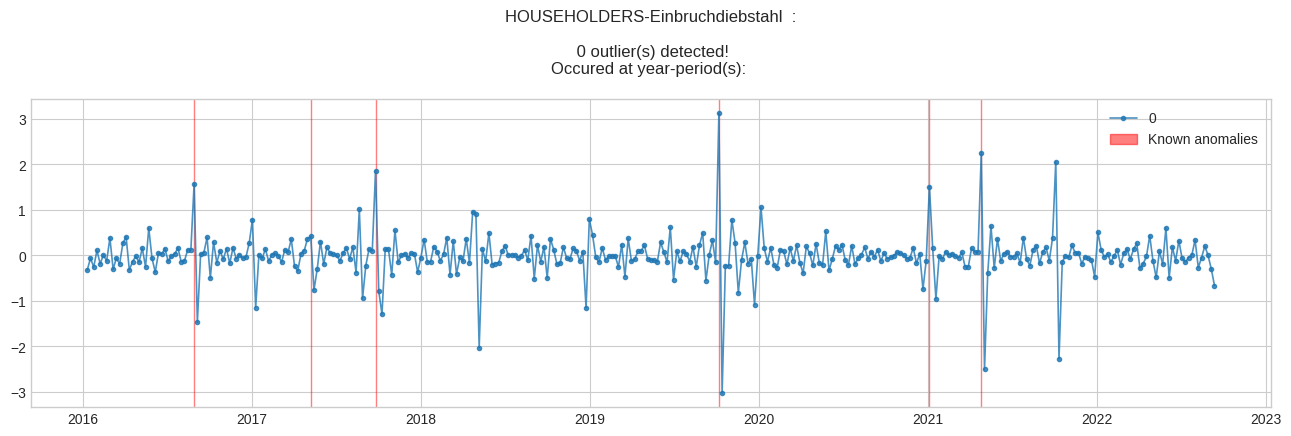

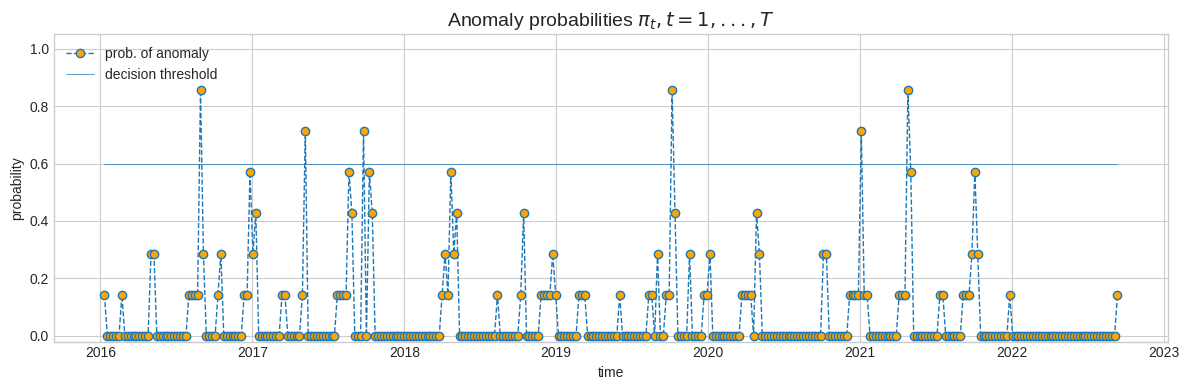

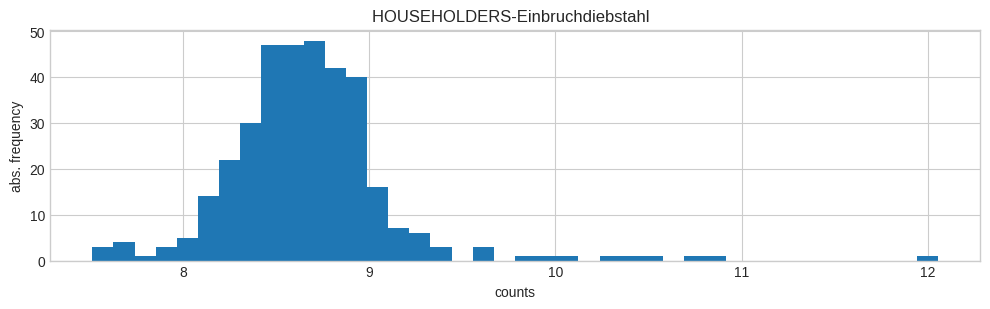

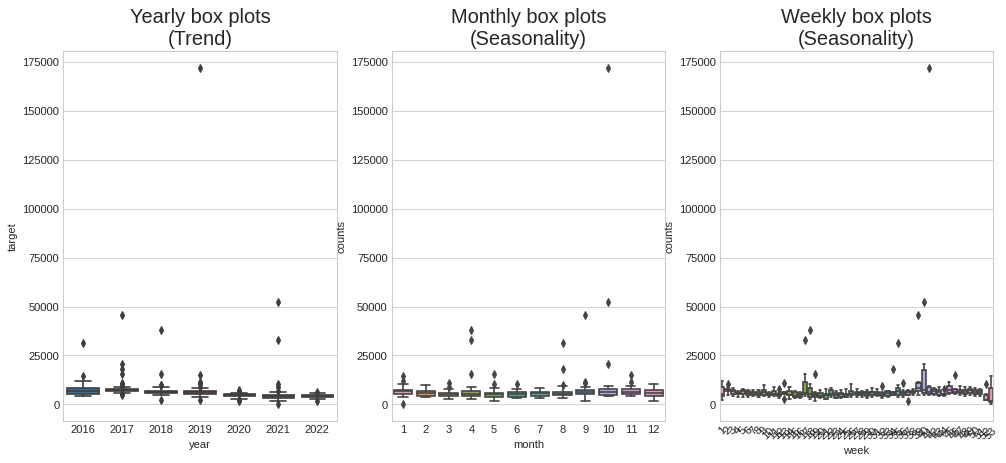

In [22]:
from adtk.visualization import plot
import statsmodels.api as sm
import matplotlib.ticker as ticker

# Get next series
#-------------------
label, sub_set = next(gen)

print('Claims from period {} to {}.'.format(claims.min_year_period, claims.max_year_period)) 

print(label, sub_set.shape[0])
df = deepcopy(sub_set)

train = trainer.trainer(verbose=False)
fitted = train.fit(df = df)

y = fitted.ts_values
#y = fitted.val_series
out = fitted.predict(detect_thresh = None)

where = np.where(np.array(claims.time_index) == outlier_filter)[0][0]
outlier_search_list = claims.time_index[where:]

filtered_outliers = []
if out.nof_outliers > 0:
    outlier_dates = out.outlier_dates
    filt = [outl in outlier_search_list for outl in outlier_dates]
    filtered_outliers = np.array(outlier_dates)[filt].tolist()
    
    if len(filtered_outliers) > 0:
        #print("\nSeries",i)
        #print(label, sub_set.shape[0])
        print("Anomaly found!")
        print(filtered_outliers)
    
#lag = 1
#y_diff = util.difference(y, lag)
# First diff.
#util.ts_plot(x=x[lag:], y=y_diff, title='Weekly claim counts (First diff.): '+label) 

# Detect anomalies:
#----------------------
inside = ''    
if label in list(claims.level_wise_aggr.keys()):

    inside = claims.level_wise_aggr[label]       # then shows over which set it was aggregated    
    #new_inside = [str(i)+'\n' for i in inside] 
    
    #main = label +':\n\n '+ str(len(filtered_outliers)) + \
    #    ' outlier(s) detected!\n' + 'Occured at year-calendar week(s): '+ \
    #    ', '.join(filtered_outliers)+'\n'+'Aggregated over:'+str(new_inside)+'\n'
    
    main = label +':\n\n '+ str(len(filtered_outliers)) + \
            ' outlier(s) detected!\n' + 'Occured at year-period(s): '+ \
            ', '.join(filtered_outliers)+'\n'+'\nAggregated over: '
    for i in inside: main += str(i)+'\n'
    
else:
    main = label +':\n\n '+ str(len(filtered_outliers)) + \
        ' outlier(s) detected!\n' + 'Occured at year-period(s): '+ \
        ', '.join(filtered_outliers)+'\n'

    
pp = plot(fitted.val_series, anomaly_true = fitted.anomalies, ts_linewidth=1.2, ts_markersize=6, 
     at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, title = main)


# other change point detection algos
#model = "rbf"  # "l2", "rbf"
#signal = train.s_deseasonal.to_numpy()
#signal = y.to_numpy()
#algo = rpt.Pelt(model=model, min_size=5).fit(signal)
#algo = rpt.Binseg(model=model).fit(signal)
#my_bkps = algo.predict(pen=np.log(len(signal))*np.std(signal)**2)

#ind = np.zeros(len(fitted.anomalies))
#ind[np.array(my_bkps)-1] = 1
#anomalies_algo = pd.Series(ind,name=fitted.anomalies.name, index=fitted.anomalies.index)
#bb = plot(fitted.val_series, anomaly_true = anomalies_algo, ts_linewidth=1.2, ts_markersize=6, 
#     at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, title = "Algo")

#ticklabels = pp.get_xticks().tolist()
#pp.set_xticklabels(df['time'].tolist())
#pp.get_xticklabels()
#pp.get_xticks().tolist()
#pp.set_xticklabels(a)

# Anomaly probabilities:
#-------------------------
plt.figure(figsize=(12,4), dpi=100)
pro = plt.plot(fitted.anomaly_proba.index, fitted.anomaly_proba, color='tab:blue',label="prob. of anomaly", linestyle='--', marker='o', markerfacecolor='orange', linewidth=1)
plt.plot(fitted.anomaly_proba.index, [fitted.detect_thresh]*len(fitted.anomaly_proba.index), label="decision threshold",  linewidth=.5)
plt.gca().set(title="", xlabel="time", ylabel="probability", ylim = plt.ylim(-0.02, 1.05))   #plt.xlim(left=0)
locs, labels = plt.xticks()
#plt.xticks(y.index[0::3], labels=df['time'].to_numpy()[0::3], rotation=60)
plt.title(r'Anomaly probabilities $\pi_{t}, t=1,...,T$', fontdict = {'fontsize' : 14})
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()  

#start, end = pp.get_xlim()
#pp.xaxis.set_ticks(np.linspace(start, end, num=len(fitted.df['time'].values.tolist()[0::3])))
#pp.set_xticklabels(fitted.df['time'].values.tolist()[0::3], rotation=65)

#pp.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Density plots
#----------------------------------------------------
plt.figure(figsize=(12,3), dpi=100)
#plt.subplot(211)
y.hist(bins=40)
plt.gca().set(title=label, xlabel="counts", ylabel="abs. frequency")
#--------------------------------------------------------------------
#plt.subplot(212)
#log_y = np.log(1 + y)
#log_y.hist(bins=15)
#plt.gca().set(title='', xlabel="log counts", ylabel="abs. frequency")
#plt.subplot(212)
#y.plot(kind='kde')
#plt.gca().set(title='', xlabel="counts", ylabel="density")
#------------------------------------------------------------------------
# Draw Boxplot
if periodicity == 52 :
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6), dpi= 80)
if periodicity == 12 :    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), dpi= 80)
sns.boxplot(x='year', y='target', data=sub_set, ax=axes[0])
sns.boxplot(x='month', y='target', data=sub_set, ax=axes[1]).set(ylabel="counts")
if periodicity == 52 :
    sns.boxplot(x='period', y='target', data=sub_set, ax=axes[2], orient='v').set(
    xlabel='week', ylabel="counts")
#------------------------------------------------------------------------------------------

# Set Titles
axes[0].set_title('Yearly box plots\n(Trend)', fontsize=18) 
axes[1].set_title('Monthly box plots\n(Seasonality)', fontsize=18)
if periodicity == 52 :
    axes[2].set_title('Weekly box plots\n(Seasonality)', fontsize=18)
#plt.yticks(rotation=15)
plt.xticks(rotation=45)
plt.show()

# Bayesian:
#trim = 3
#probm = exact_post_cp(y.values[trim:], alpha = .2, beta = .2, gamma = .2, delta = .2)

#x = np.arange(0, len(y))
#fig, ax = plt.subplots()
#rects1 = ax.bar(x, np.append(np.zeros(3), probm), label='posterior', width = 4)
#plt.title('Posterior p.m.f. of change point')
#plt.show()
#plt.plot(x,y,'b')
#plt.axvline(x[np.argmax(probm)], color='k', linestyle='--', lw=.65)


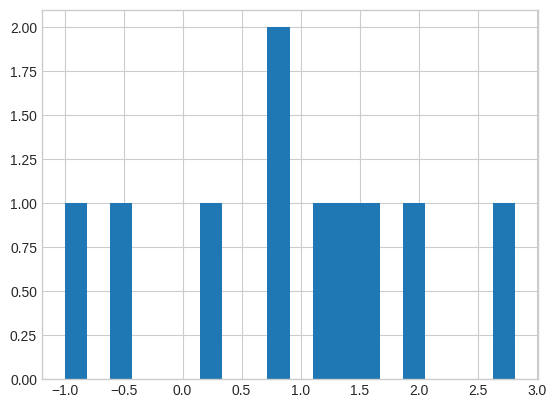

In [18]:
import matplotlib.pyplot as plt

arr = np.random.normal(1, 1, size=10)
fig, ax = plt.subplots()
ax.hist(arr, bins=20);

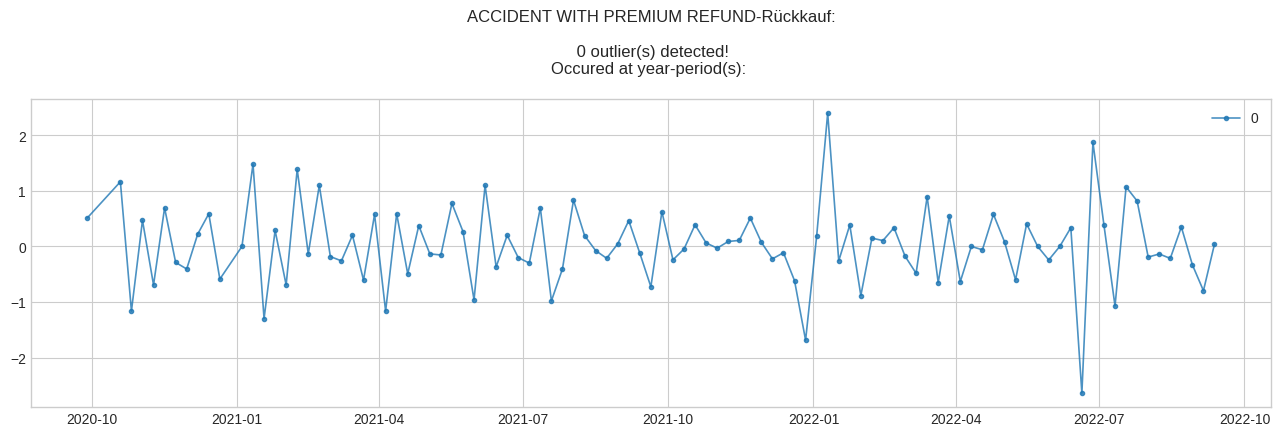

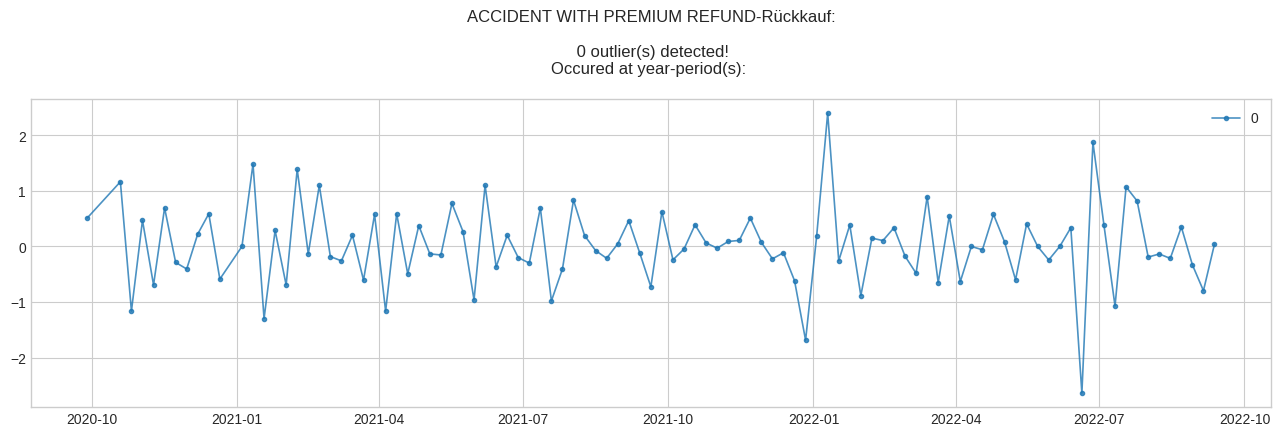

In [20]:
pp = plot(fitted.val_series, anomaly_true = fitted.anomalies, ts_linewidth=1.2, ts_markersize=6, 
     at_markersize=5, at_color='red', freq_as_period=False, ts_alpha=0.8, at_alpha=0.5, title = main)
pp.figure

In [100]:
# Get next series
#-------------------
label, sub_set = next(gen)

print(label, sub_set.shape[0])
df = deepcopy(sub_set)

df.tail()

GENERAL LIABILITY-Einbruchdiebstahl   270


,time,target,year,month,period
265,2022-33,40,2022,8,33
266,2022-34,34,2022,8,34
267,2022-35,50,2022,8,35
268,2022-36,34,2022,9,36
269,2022-37,23,2022,9,37


In [101]:

train = trainer.trainer(verbose=False)
fitted = train.fit(df = df)

y = fitted.val_series

In [56]:
#get_all = dict(gen)

In [78]:
#get_all['all']

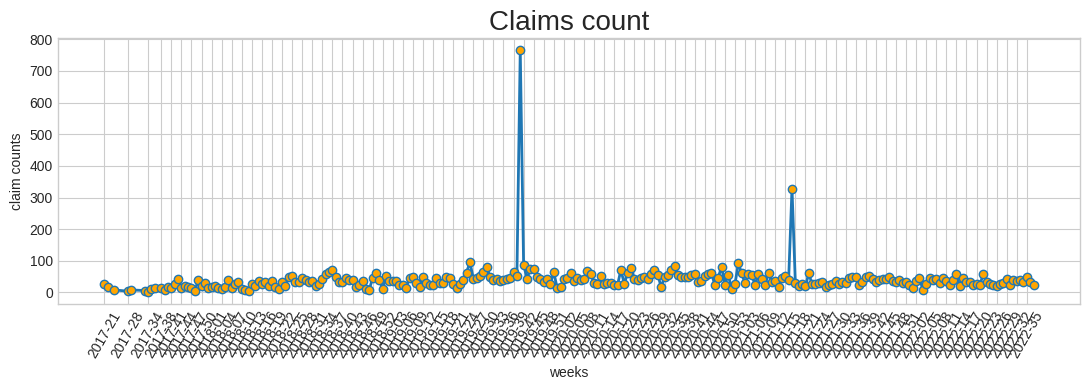

In [102]:
plt.figure(figsize=(11,4), dpi=100)
plt.plot(y.index, y, color='tab:blue', linestyle='-', marker='o', markerfacecolor='orange', linewidth=2)
plt.gca().set(title="kjds", xlabel="weeks", ylabel="claim counts", ylim = plt.ylim(), xlim=plt.xlim())   #plt.xlim(left=0)
locs, labels = plt.xticks()
plt.xticks(y.index[0::3], labels=df['time'].to_numpy()[0::3], rotation=60)
plt.title('Claims count', fontdict = {'fontsize' : 20})
plt.tight_layout()
plt.show()  

In [103]:
from datetime import datetime
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, QuantileAD
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate, Retrospect
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test
from adtk.visualization import plot
from adtk.transformer import DoubleRollingAggregate, ClassicSeasonalDecomposition
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test


In [113]:
from adtk.transformer import Retrospect

s = validate_series(y)

#embed = Retrospect(n_steps=4, step_size=1).transform(s)

#plot(pd.concat([s, embed], axis=1), curve_group="all");

In [126]:
steps = [
    ("deseasonal", ClassicSeasonalDecomposition(freq=52, trend = False))
    #("quantile_ad", QuantileAD(high=0.995, low=0.005))
]

pipeline = Pipeline(steps)

#pipeline.fit_transform(s)
s.head()

year_period_ts
2017-05-22    28
2017-05-29    16
2017-06-12     8
2017-07-10     4
2017-07-17     8
Name: target, dtype: int64

In [123]:
from adtk.data import resample

s_train = resample(s, dT='W-MON')

In [127]:
s_train.head()

2017-05-22    28.0
2017-05-29    16.0
2017-06-05    12.0
2017-06-12     8.0
2017-06-19     7.0
Freq: W-MON, Name: target, dtype: float64

In [129]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)
anomalies.head()

year_period_ts
2017-05-22    False
2017-05-29    False
2017-06-12    False
2017-07-10     True
2017-07-17    False
Name: target, dtype: bool

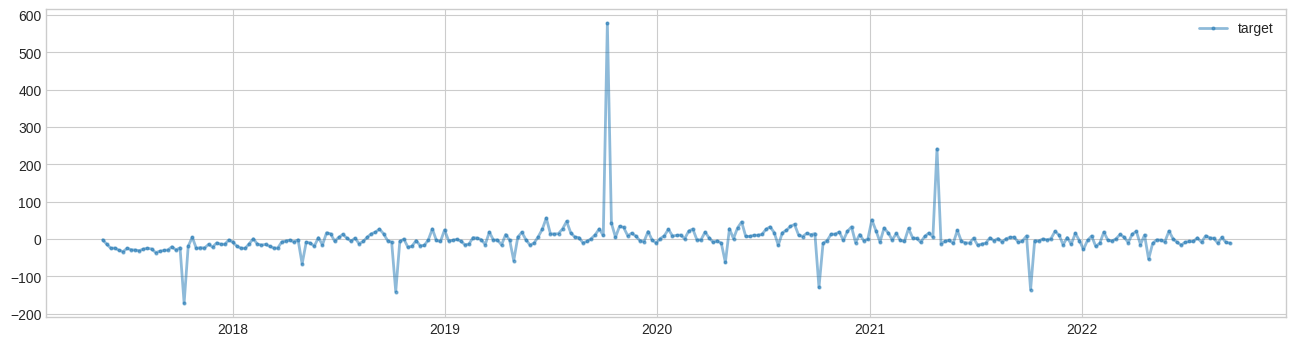

In [130]:
plot(pipeline.fit_transform(s_train), ts_linewidth=2, ts_markersize=4);

#s_transformed = ClassicSeasonalDecomposition(freq=52, trend=False).fit_transform(s).rename("Seasonal decomposition residual")
#plot(pd.concat([s, s_transformed], axis=1), ts_markersize=4, ts_linewidth=2.5);


In [28]:
from adtk.detector import PcaAD
from adtk.data import validate_series
df = validate_series(mv)
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(df)

In [30]:
from adtk.transformer import PcaReconstructionError
s = PcaReconstructionError(k=1).fit_transform(df).rename("PCA Reconstruction Error")
#plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "PCA Reconstruction Error"]);

## Test reports:

In [58]:
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate, Retrospect
from adtk.pipe import Pipeline, Pipenet

from adtk.detector import ThresholdAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, QuantileAD
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate, Retrospect
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test

In [59]:
#?LevelShiftAD

In [61]:
filt_suspects#['filtered_outliers']

{'Aviation-US-North America': ['2020-09'],
 'Entertainment-US-North America': ['2020-09'],
 'Marine-Germany-CEE': ['2020-07', '2020-08'],
 'Marine-UK-RUL': ['2020-04'],
 'Marine-US-North America': ['2020-09'],
 'MidCorp-US-North America': ['2020-04'],
 'UK-RUL': ['2020-04'],
 'CEE': ['2020-05', '2020-09']}

In [25]:
# Call class:
#---------------
reload(util)

claims = util.claims_reporting()

gen = claims.process_data(data_orig, ignore_week_lag = 2, min_sample_size = 20)

#get_all = list(gen)
#get_all[0]

In [26]:
# Get next series
#-------------------
label, sub_set = next(gen)
print(label, sub_set.shape[0])

df = deepcopy(sub_set)
fitted = train.fit(df)
y = fitted.ts_values
out = fitted.predict()


Ignoring claims younger than: 2020-10
Finished data preprocessing.
Number of left over aggregations: 4
Aviation-Germany-CEE 219


In [108]:
# https://arundo-adtk.readthedocs-hosted.com/en/stable/userguide.html

from datetime import datetime
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, QuantileAD
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate, Retrospect
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test
from adtk.visualization import plot
from adtk.transformer import DoubleRollingAggregate, ClassicSeasonalDecomposition
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test


label, sub_set = next(gen0)

print(label, sub_set.shape[0])

df = deepcopy(sub_set)
fitted = train.fit(df = df)

#y.index = x
s = fitted.val_series

#s = label_series['UK-RUL']
X_lag = util.embed_ts(data = pd.DataFrame(y.values, columns=["y"], index = y.index), lags= 10, dropnan=True)

s_X = validate_series(X_lag)

Parameters: ignore_week_lag 1, min_sample_size 30, min_median_cnts 50.
Ignoring claims younger than: 2020-15 in detection
Finished data preprocessing.
Number of left over aggregations: 4
Aviation-Germany-CEE 224
QuantileAD
PersistAD
GeneralizedESDTestAD
LevelShiftAD
VolatilityShiftAD
InterQuartileRangeAD
AutoregressionAD


In [110]:
s.shape

(222,)

In [122]:
#? ClassicSeasonalDecomposition

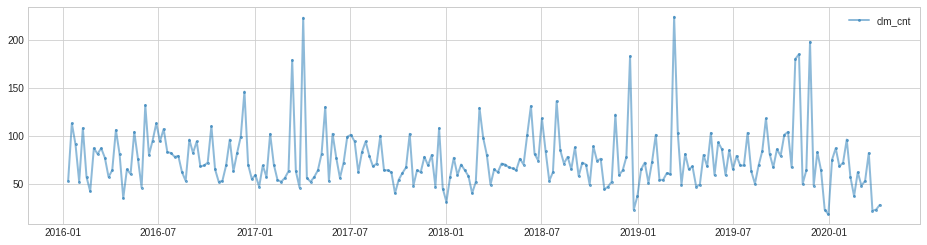

In [124]:
plot(s, ts_linewidth=2, ts_markersize=4);

In [147]:
threshold_ad = ThresholdAD(high=10, low=2)    # set business threshold
anomalies = threshold_ad.detect(s)

In [49]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(s)

In [103]:
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)

In [67]:
# Please note a key assumption of generalized ESD test is that normal values follow an approximately normal distribution. 
# Please only use this detector when this assumption holds.
esd_ad = GeneralizedESDTestAD(alpha=0.5)

anomalies = esd_ad.fit_detect(s)

In [70]:
persist_ad = PersistAD(c=3.0, side='positive')   # DoubleRollingAggregate
anomalies = persist_ad.fit_detect(s)

In [198]:
persist_ad = PersistAD(c=1.5, side='negative')
anomalies = persist_ad.fit_detect(s)

In [210]:
persist_ad.window = 5
anomalies = persist_ad.fit_detect(s)

In [124]:
seasonal_ad = SeasonalAD(freq=7, c = 1.0, side='both', trend=True)
anomalies = seasonal_ad.fit_detect(s)

In [75]:
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=4)
anomalies = level_shift_ad.fit_detect(s)

In [95]:
volatility_shift_ad = VolatilityShiftAD(c=2, side='both', window=4, agg = "std")
anomalies = volatility_shift_ad.fit_detect(s)

Plot stuff:

4


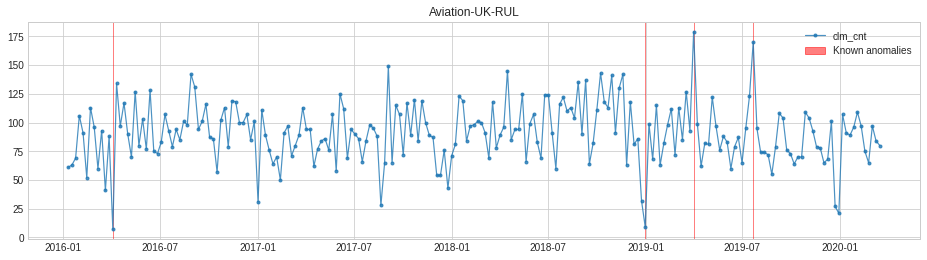

In [122]:
plot(s, anomaly_true = anomalies, ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5, title = label)

print(np.nansum(anomalies))

In [266]:
#seasonal_ad = SeasonalAD(c=2.0, side="left")
#anomalies = seasonal_ad.fit_detect(s)

In [19]:
lags = 1
autoregression_ad = AutoregressionAD(n_steps=lags, step_size=1, c=3.0, side = "both")
anomalies = autoregression_ad.fit_detect(s)

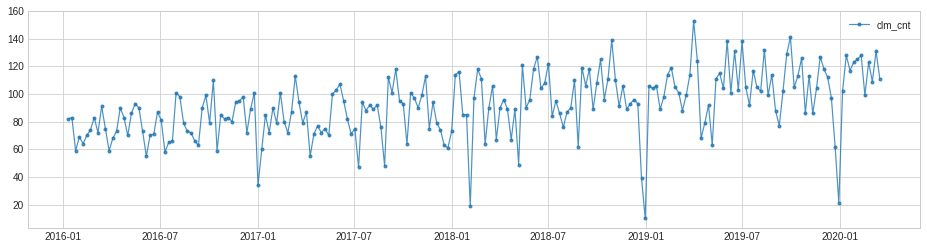

In [28]:
plot(s, anomaly_true=anomalies, ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5)

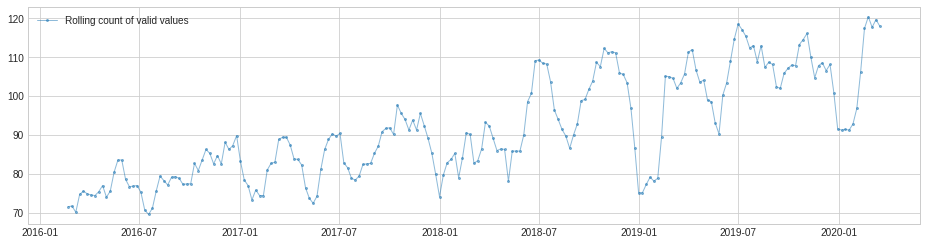

In [181]:
s_transformed = RollingAggregate(agg='mean', window=7).transform(s)

plot(s_transformed.rename("Rolling count of valid values"), ts_linewidth=1, ts_markersize=4);

In [278]:
s_transformed = DoubleRollingAggregate(
    agg="quantile", #agg="mean",
    agg_params={"q": [0.1, 0.5, 0.9]},
    window=10).transform(s).rename("Diff rolling quantiles")

In [280]:
s_transformed = DoubleRollingAggregate(
    agg="std",
    window=10,
    diff="diff").transform(s).rename("Diff rolling median")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8fa438e48>,
      dtype=object)

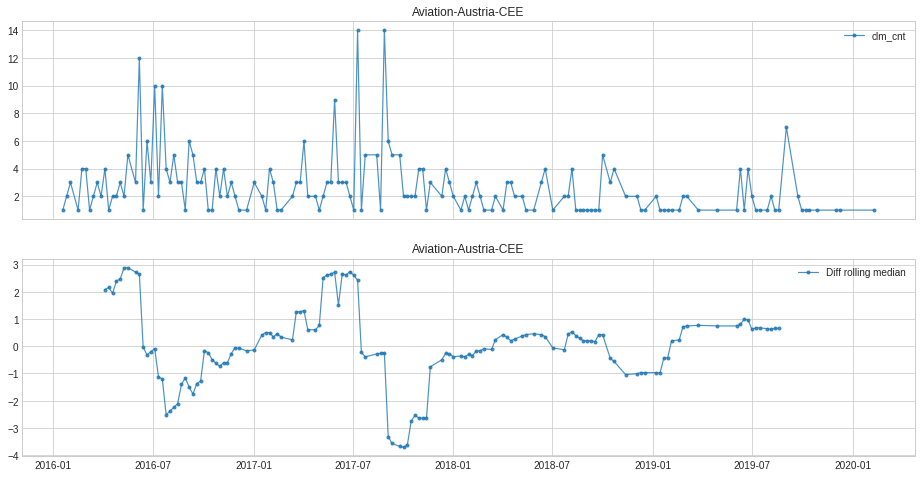

In [281]:
plot(pd.concat([s, s_transformed], axis=1), ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5, title = label)

In [275]:
#s_transformed = ClassicSeasonalDecomposition().fit_transform(s).rename("Seasonal decomposition residual")

#plot(pd.concat([s, s_transformed], axis=1), ts_markersize=1);

In [21]:
steps = [
    ("rolling", DoubleRollingAggregate(agg="median", window=10, diff="diff")),
    ("quantile_ad", QuantileAD(high=0.99, low=0.1))
]
pipeline = Pipeline(steps)

anomalies = pipeline.fit_detect(s)

NameError: name 'QuantileAD' is not defined

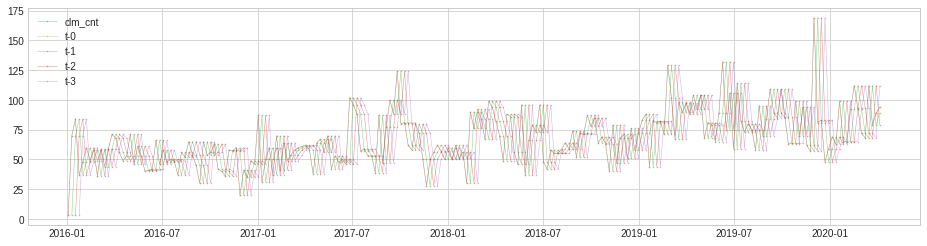

In [298]:
from adtk.transformer import Retrospect

s = validate_series(y)
df = Retrospect(n_steps=4, step_size=1).transform(s)
plot(pd.concat([s, df], axis=1), curve_group="all");

In [105]:
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, InterQuartileRangeAD, GeneralizedESDTestAD, PersistAD, QuantileAD
from adtk.detector import LevelShiftAD, VolatilityShiftAD, SeasonalAD, AutoregressionAD
from adtk.transformer import DoubleRollingAggregate, RollingAggregate
from adtk.pipe import Pipeline, Pipenet
from adtk.aggregator import AndAggregator, OrAggregator
from adtk.data import split_train_test

ar_lags = 1

hyper_para = {'RollingAggregate': {'agg':'mean', 'window':10},
              'DoubleRollingAggregate': {'agg':'mean', 'window':10, "diff":"diff"},
             'QuantileAD': {'high': 0.995, 'low' : 0.005}, 
             'GESD_test': {'alpha' : 0.3}, 
             'VolatilityShiftAD': {'c': 6, 'side':'positive', 'window':10, 'agg' : "idr"}, 
             'InterQuartileRangeAD': {'c': 3.0}, 
             'AutoregressionAD': {'n_steps': 1, 'step_size':1, 'c': 3.0, 'side':  "both"}}

steps = {
            #"double_roll_transf": {
            #    "model": DoubleRollingAggregate(**hyper_para['DoubleRollingAggregate']),
            #    "input": "original"
            #},
           "roll_transf": {
                "model": RollingAggregate(**hyper_para['RollingAggregate']),
                "input": "original"
            },   
            "vola_shift": {
                "model": VolatilityShiftAD(**hyper_para['VolatilityShiftAD']),   # generalized extreme Studentized deviate (ESD) test
                "input": "roll_transf"
            },    
            "GESD_test": {
                "model": GeneralizedESDTestAD(**hyper_para['GESD_test']),   # generalized extreme Studentized deviate (ESD) test
                "input": "original"
            },
            #"AR_res_shift": {
            #    "model": AutoregressionAD(**hyper_para['AutoregressionAD']),
            #    "input": "double_roll_transf"
            #},
            "IQ_shift": {
                "model": InterQuartileRangeAD(**hyper_para['InterQuartileRangeAD']),
                #"input": "original"
                "input": "roll_transf"
            },
            #"quantile_shift": {
            #    "model": QuantileAD(**hyper_para['QuantileAD']),
            #    #"input": "original"
            #    "input": "roll_transf"
            #},
            "positive_level_shift": {
                #"model": AndAggregator(),
                "model": OrAggregator(),
                "input": [#"quantile_shift", 
                          "IQ_shift", 
                          #"AR_res_shift", 
                          "GESD_test", "vola_shift"]
            }
        }

pipenet = Pipenet(steps)

anomalies = pipenet.fit_detect(s)

In [300]:

from adtk.pipe import Pipeline
steps = [
    ("Roll", RollingAggregate(**hyper_para['RollingAggregate'])),
    ("quantile_ad", QuantileAD(high=0.995, low=0.005))
]
pipeline = Pipeline(steps)

anomalies = pipeline.fit_detect(s)

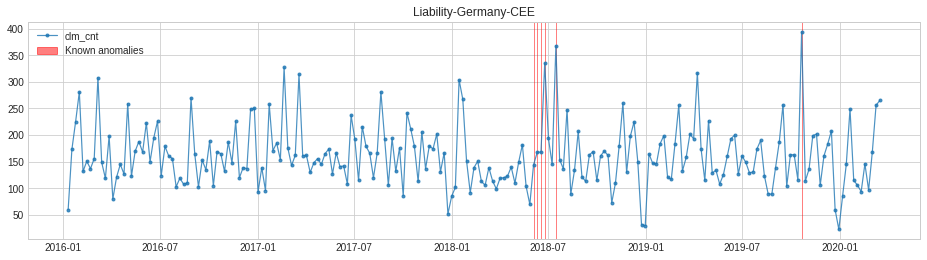

In [106]:
plot(s, anomaly_true=anomalies, ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5, title = label)

In [50]:
ar_lags = 1

steps = {
    #"roll_transf": {
    #    "model": DoubleRollingAggregate(
    #        agg="mean",
    #        window=1,
    #        center=True,
    #        diff="diff"
    #    ),
    #    "input": "original"
    #},
    "GESD_test": {
        "model": GeneralizedESDTestAD(alpha=0.3),   # generalized extreme Studentized deviate (ESD) test
        "input": "original"
    },
    "AR_res_shift": {
        "model": AutoregressionAD(n_steps = ar_lags, step_size=1, c=3.0, side = "both"),
        "input": "original"
    },
    "IQ_shift": {
        "model": InterQuartileRangeAD(c=3.0),
        "input": "original"
        #"input": "roll_transf"
    },
    "quantile_shift": {
        "model": QuantileAD(high=0.98, low=0.01),
        "input": "original"
        #"input": "roll_transf"
    },
    "positive_level_shift": {
        #"model": AndAggregator(),
        "model": OrAggregator(),
        #"input": ["level_shift", "quantile_shift"]
        "input": ["quantile_shift", "IQ_shift", "AR_res_shift", "GESD_test"]
    }
}

pipenet = Pipenet(steps)

anomalies = pipenet.fit_detect(s)

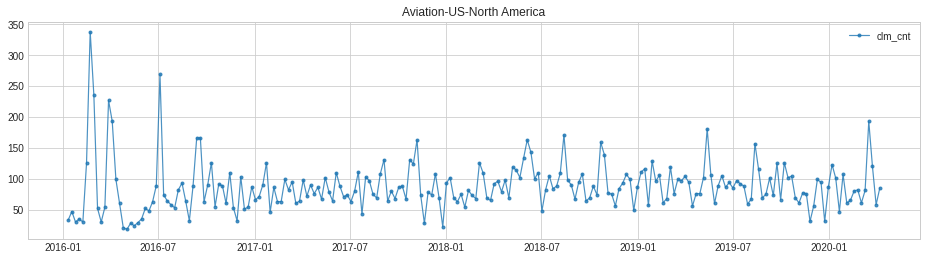

In [51]:
from adtk.detector import RegressionAD
from sklearn.linear_model import LinearRegression

regression_ad = RegressionAD(regressor=LinearRegression(), target="y_lag0", c=3.0)
#anomalies = regression_ad.fit_detect(X_lag)


from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans

min_cluster_detector = MinClusterDetector(KMeans(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(X_lag)

from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(X_lag)

from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(X_lag)

plot(s, anomaly_true=anomalies, ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5, title = label)

In [301]:
from sklearn.ensemble import IsolationForest

X_lag = util.embed_ts(data = pd.DataFrame(y.values, columns=["y"], index = y.index), lags= 20, dropnan=True)
print(X_lag.shape)

s = validate_series(X_lag)
yhat = IsolationForest().fit_predict(df)
anomalies = (yhat == -1)#.tolist()
anomalies

(203, 21)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

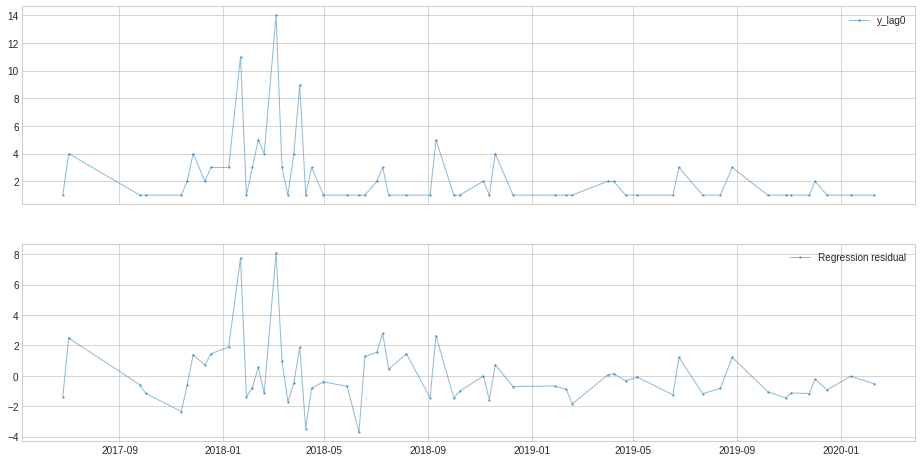

In [151]:
from adtk.transformer import RegressionResidual
from sklearn.linear_model import LinearRegression

s = RegressionResidual(regressor=LinearRegression(), target="y_lag0").fit_transform(X_lag).rename("Regression residual")
plot(pd.concat([X_lag['y_lag0'], s], axis=1), ts_linewidth=1, ts_markersize=3)

In [139]:
?plot

In [101]:
#pipenet.plot_flowchart();

In [102]:
#pipenet.summary()

In [103]:
#pipenet.get_params()

In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs

In [166]:
#X_lag.tail(10)
target = "y_lag0"

In [179]:
Xy_train, Xy_test = util.train_test_split(X_lag, n_test = 10)
                                          
print(Xy_train.shape)
print(Xy_test.shape)

(48, 11)
(10, 11)


In [180]:
y_test = Xy_test[target]
y_train = Xy_train[target]
X_test = Xy_test.drop(target, axis=1, inplace=False)
X_train = Xy_train.drop(target, axis=1, inplace=False)

print(X_train.shape)
print(X_test.shape)

(48, 10)
(10, 10)


In [189]:
scaler = StandardScaler().fit(X_train)
scaler

scaler.mean_
scaler.scale_

# Do it for the training set:
Xtrain_z = scaler.transform(X_train)
# apply it to the test set
Xtest_z = scaler.transform(X_test)

#np.corrcoef(Xtrain_z)

#Xtrain_z.mean(axis=0)
#Xtrain_z.std(axis=0)

In [203]:
RF = RandomForestRegressor(n_estimators = 100, min_samples_leaf=1)

RF_fit = RF.fit(X_train, y_train)

yhat_train = RF_fit.predict(X_train)
yhat_test = RF_fit.predict(X_test)

RF_mse_train = mean_squared_error(y_train, yhat_train)         # MSE
RF_mse_test = mean_squared_error(y_test, yhat_test)         

RF_rmse_train = np.sqrt(RF_mse_train)                       # RMSE
RF_rmse_test = np.sqrt(RF_mse_test)                       

print(RF_rmse_train)
print(RF_rmse_test)

1.2327552136035225
0.8907524908749905


In [ ]:
from adtk.transformer import PcaProjection

s = PcaProjection(k=1).fit_transform(X_lag)
plot(pd.concat([df, s], axis=1), ts_linewidth=1, ts_markersize=3, curve_group=[("Speed (kRPM)", "Power (kW)"), "pc0"]);

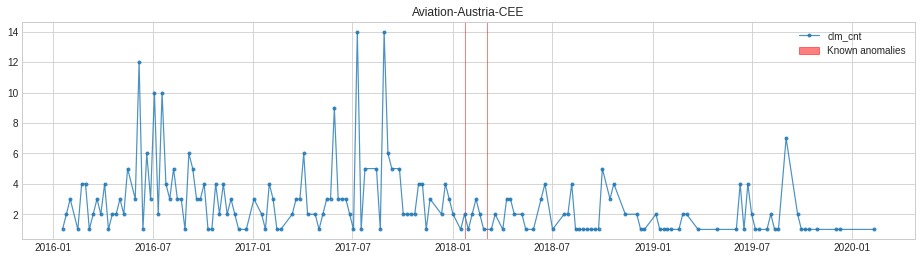

In [218]:
plot(s, anomaly_true=anomalies, ts_linewidth=1.2, ts_markersize=6, at_markersize=5, at_color='red', freq_as_period=False,
     ts_alpha=0.8, at_alpha=0.5, title = label)

In [55]:
#?plot

In [7]:
df = deepcopy(data_orig)

## Facebook Prophet:

In [232]:
from fbprophet import Prophet

In [253]:
y = fitted.ts_values

In [254]:
dat = y.reset_index().rename(columns={'year_week_ts': 'ds', 'clm_cnt': 'y' })

In [256]:
dat.head()

,ds,y
0,2016-01-11,4
1,2016-01-18,6
2,2016-01-25,6
3,2016-02-01,2
4,2016-02-08,1


In [257]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)

m.fit(dat)

future = m.make_future_dataframe(periods=213)

forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


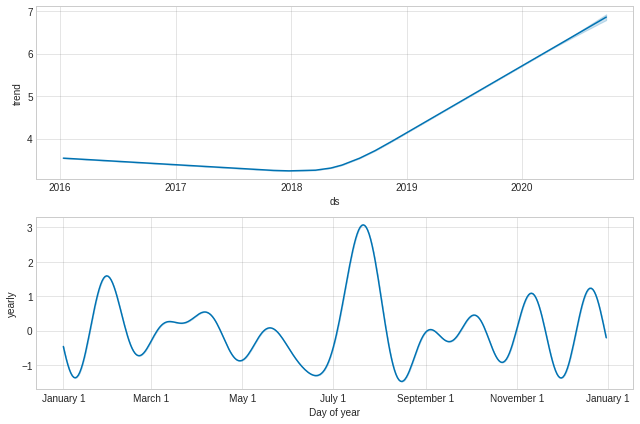

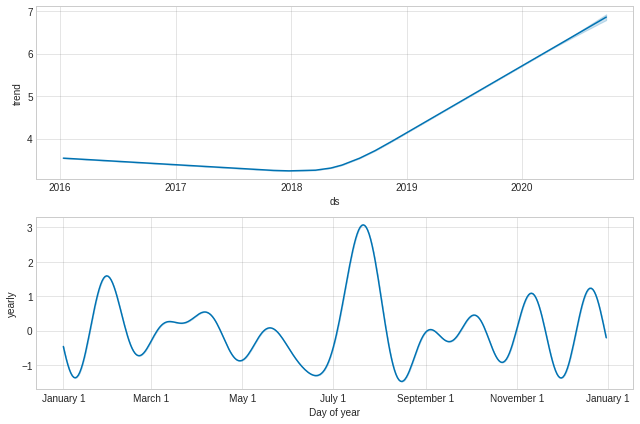

In [258]:
m.plot_components(forecast)

In [259]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
ds    176 non-null datetime64[ns]
y     176 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB


### Decomposition

In [135]:
import statsmodels.api as sm
from statsmodels.tsa import seasonal as sea

In [141]:
#pd.DatetimeIndex(freq="w", start=0, periods=14)

# Multiplicative Decomposition 
result_mul = sea.seasonal_decompose(y, model='multiplicative', extrapolate_trend='freq', freq=52)

In [142]:
# Additive Decomposition
result_add = sea.seasonal_decompose(y, model='additive', extrapolate_trend='freq', freq=52)

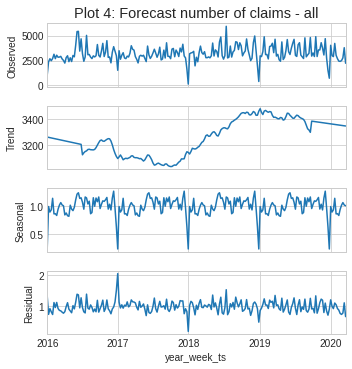

In [191]:
# Plot
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'figure.figsize': (5,5)})
fig = result_mul.plot()#.title('Multiplicative Decompose', fontdict = {'fontsize' : 17})
axes_dc = fig.get_axes()
axes_dc[0].set_title("Plot 4: Forecast number of claims - "+label, fontsize=14.5)
axes_dc[0].set_xlabel('time index')
#plt.title('subplot 2')
#result_add.plot().suptitle('Additive Decompose', fontsize=15)
plt.show()


### Test for non-stationarity

In [830]:
# ADF Test
result = adfuller(sub_set['clm_cnt'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.501014165539718
p-value: 3.445156629805399e-16
Critial Values:
   1%, -3.470126426071447
Critial Values:
   5%, -2.8790075987120027
Critial Values:
   10%, -2.5760826967621644


In [831]:
# KPSS Test
result = kpss(sub_set['clm_cnt'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.590711
p-value: 0.023481
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [832]:
y = sub_set['clm_cnt'].values

## Detrend series

Text(0.5, 1.0, 'Detrended by subtracting the least squares fit')

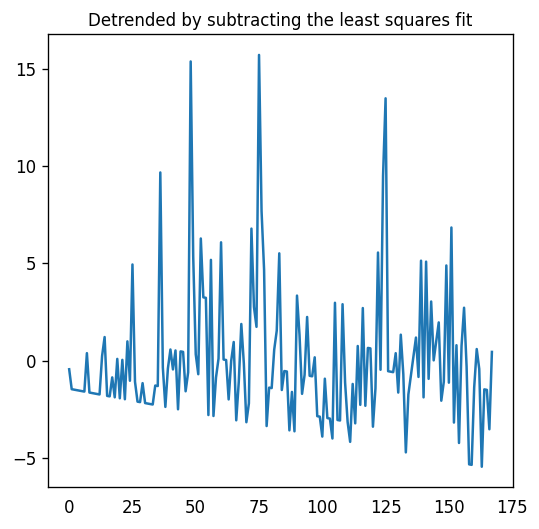

In [833]:
from scipy import signal

detrended = signal.detrend(y)
plt.plot(detrended)
plt.title('Detrended by subtracting the least squares fit', fontsize=10)

Text(0.5, 1.0, 'Detrended by subtracting the trend component\n (from decomp.)')

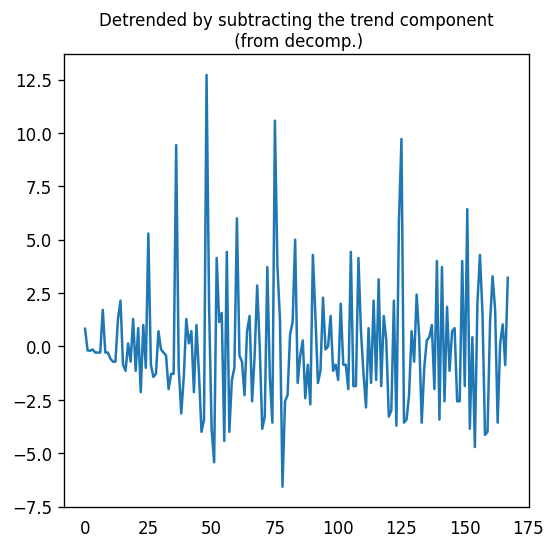

In [834]:
# Using statmodels: Subtracting the Trend Component.
detrended = y - result_mul.trend
plt.plot(detrended)
plt.title('Detrended by subtracting the trend component\n (from decomp.)', fontsize=10)

## Seasonal adjust sereis:

In [835]:
# Deseasonalize
deseasonalized = y / result_mul.seasonal

[]

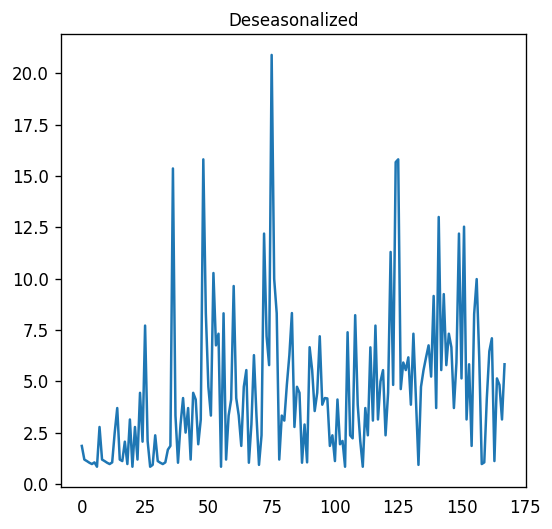

In [836]:
# Plot
plt.plot(deseasonalized)
plt.title('Deseasonalized', fontsize=10)
plt.plot()

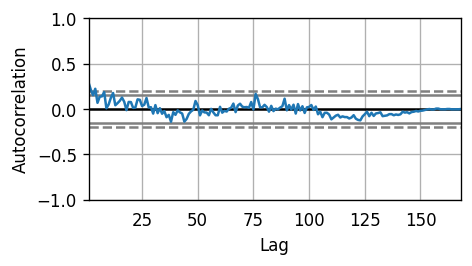

In [837]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(4,2), 'figure.dpi':120})
autocorrelation_plot(y.tolist())

In [838]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

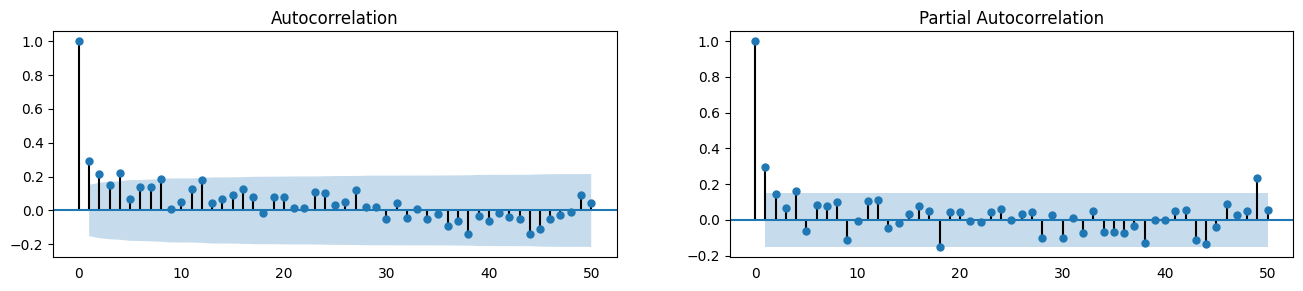

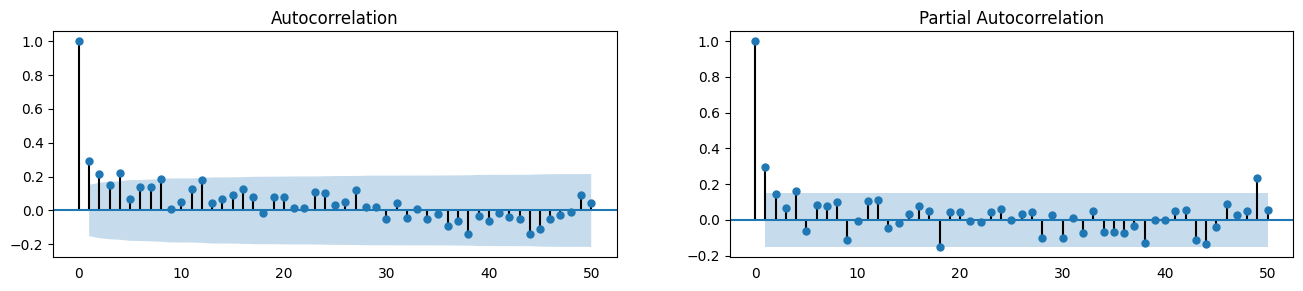

In [839]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(y.tolist(), lags=50, ax=axes[0])
plot_pacf(y.tolist(), lags=50, ax=axes[1])

### forecastability:
https://en.wikipedia.org/wiki/Approximate_entropy

In [840]:
# The higher the approximate entropy, the more difficult it is to forecast it.
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(y, m=2, r=0.2*np.std(y)))     

0.76307904666373


In [841]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(y, m=2, r=0.2*np.std(y)))      

1.466337068793427


## Smoothing of the series:

In [842]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

In [843]:
# 1. Moving Average
df_ma = sub_set['clm_cnt'].rolling(window=3, center=True).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(sub_set['clm_cnt'], np.arange(len(sub_set['clm_cnt'])), frac=0.05)[:, 1], index=sub_set['clm_cnt'].index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(sub_set['clm_cnt'], np.arange(len(sub_set['clm_cnt'])), frac=0.15)[:, 1], index=sub_set['clm_cnt'].index, columns=['value'])


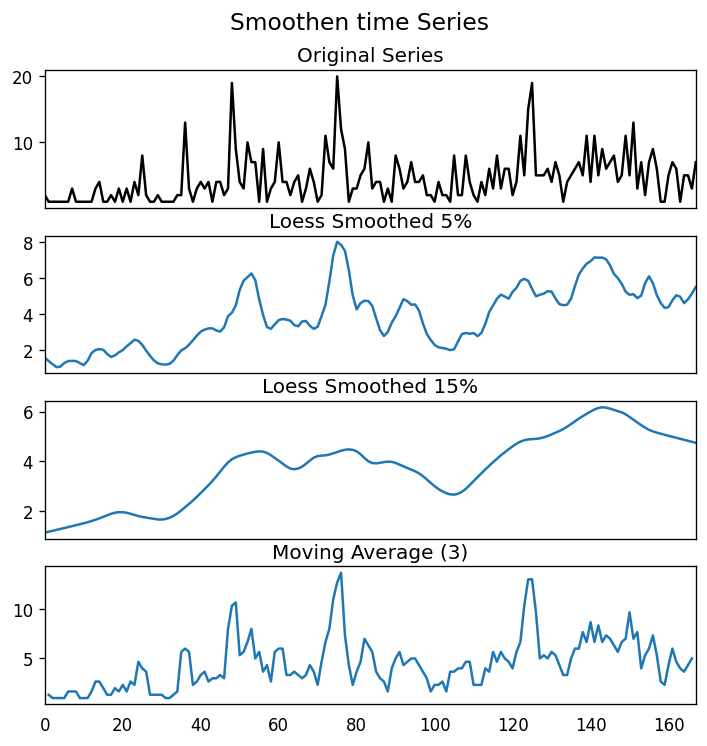

In [844]:
# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
sub_set['clm_cnt'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('Smoothen time Series', y=0.95, fontsize=14)
plt.show()

# Model building

In [30]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA
#from statsmodels.tsa.vector_ar.var_model import VAR
#from statsmodels.tsa.statespace.varmax import VARMAX
#from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### ExponentialSmoothing

In [87]:
mod = ExponentialSmoothing(endog=y, trend='additive', damped=False, seasonal="additive", seasonal_periods=7)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [88]:
res = mod.fit(use_boxcox=True)

In [63]:
res.bic

240.54511743631002

In [76]:
yhat_train = mod.predict(res.params, start=0)
len(y)
yhat_train

array([ 7.48884995, 10.80000009, 10.83127907, 10.52352266,  9.19738802,
        9.92227934, 10.8499701 ,  6.16658529,  8.60098833,  8.7206894 ,
        8.19287924,  7.33258484,  7.37519511,  8.78885322,  5.79960495,
        7.62236885,  8.24783504,  6.76777162,  6.72925857,  8.21276734,
        9.12827987,  5.67355173,  7.14270704,  7.15146225,  6.89343367,
        5.48249933,  6.42207369,  7.55241032,  4.78842259,  6.1192479 ,
        5.80303715,  5.18103527,  5.23111433,  5.89964321,  6.92767903,
        4.4750444 ,  5.23173856,  5.36749447,  5.17436449,  4.35778545,
        5.07988205,  5.30002223,  3.36755171,  4.2860549 ,  4.17592804,
        4.19309405,  3.58189928,  3.97365306,  4.61329151,  2.6113568 ,
        3.71982115,  3.93575937,  3.19468367,  2.77695298,  2.84003857,
        2.90718249,  1.73414643,  2.3449095 ,  2.15289302,  1.80202621,
        1.4537688 ,  1.5554719 ,  1.66370195,  0.90594629,  1.21613441,
        1.16720757,  1.17103806,  0.97611782,  1.21398061,  1.49

In [77]:
res.fcastvalues
yhat_train_oos = res.fittedfcast

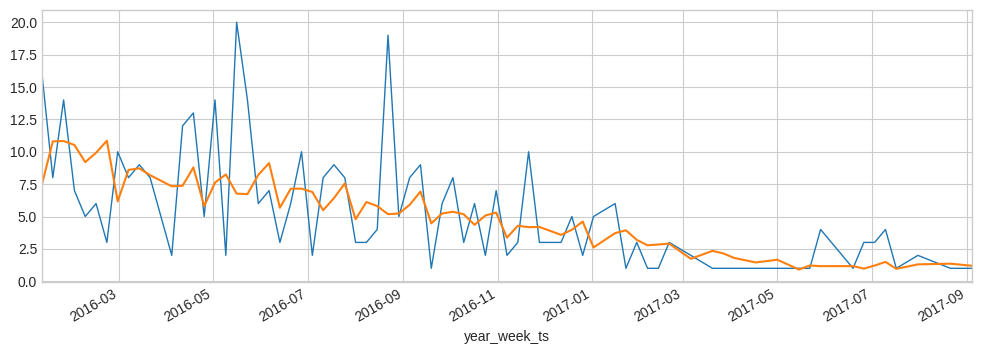

In [84]:
# Graph
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
y.plot(ax=ax, style='-', label='Observed', linewidth=1)
pd.Series(yhat_train, index=y.index).plot()
# Plot predictions
#predict_mle.predicted_mean.plot(ax=ax, style='--', label='One-step-ahead forecast', linewidth=1)
#ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
#ax.set_xlabel("calendar weeks")
#ax.set_ylabel("claim counts")
#ax.legend(loc='top left')
plt.show()

## SARIMA:

In [78]:
#mod = sm.tsa.statespace.SARIMAX(y, trend='c', order=(1,0,1))
mod = SARIMAX(y, order=(2,1,0), seasonal_order=(1,1,0,7))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [79]:
res = mod.fit(disp=False)
print(res.summary())

                                 Statespace Model Results                                
Dep. Variable:                           clm_cnt   No. Observations:                   74
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 7)   Log Likelihood                -198.551
Date:                           Fri, 17 Apr 2020   AIC                            405.103
Time:                                   18:20:23   BIC                            413.862
Sample:                                        0   HQIC                           408.564
                                            - 74                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9025      0.092     -9.844      0.000      -1.082      -0.723
ar.L2         -0.4601      0.104     -4.434

In [42]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
#print(predict)
predict_ci = predict.conf_int()
print(predict_ci)

              lower clm_cnt  upper clm_cnt
year_week_ts                              
2016-01-11     -2771.864727    2771.864727
2016-01-18     -1944.045104    1976.044304
2016-01-25     -1952.044280    1968.045125
2016-02-01     -1946.044811    1974.044593
2016-02-08     -1953.044769    1967.044635
2016-02-15     -1955.044211    1965.045191
2016-02-22     -1954.044882    1966.044520
2016-02-29     -1374.970418    1396.970510
2016-03-07       -15.786441      19.788475
2016-03-14        -3.773432      24.481070
2016-03-21        -8.497694      15.420696
2016-04-04        -8.538924      15.321423
2016-04-11        -8.368387      15.481903
2016-04-18        -9.397161      13.918475
2016-04-25         4.157904      25.837581
2016-05-02        -0.631824      19.967560
2016-05-09         1.676880      21.058150
2016-05-16        -4.297086      14.236299
2016-05-23        -5.868849      12.664536
2016-05-30         0.808609      19.341994
2016-06-06         7.440504      25.973889
2016-06-13 

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Unrecognized location 'top left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


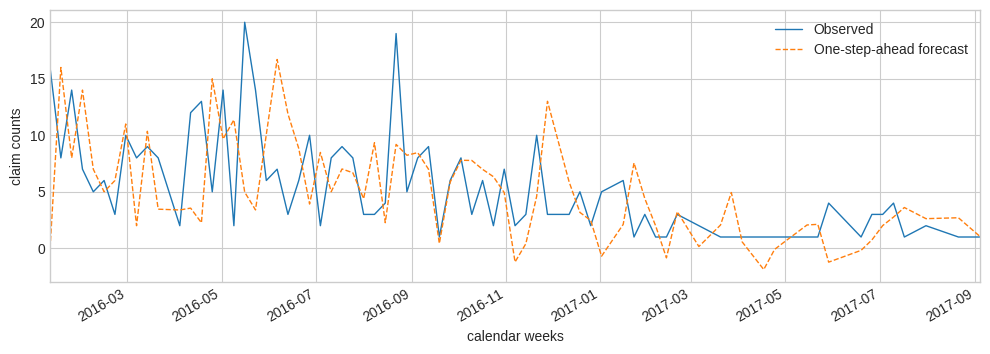

In [43]:
fcast_res1 = res.get_forecast(steps=n_step_ahead)
#print(fcast_res1.summary_frame(alpha=0.10))

predict_mle = res.get_prediction()
predict_mle_ci = predict_mle.conf_int()
lower = predict_mle_ci['lower clm_cnt']
upper = predict_mle_ci['upper clm_cnt']

# Graph
fig, ax = plt.subplots(figsize=(12,4), dpi=100)
y.plot(ax=ax, style='-', label='Observed', linewidth=1)
# Plot predictions
predict_mle.predicted_mean.plot(ax=ax, style='--', label='One-step-ahead forecast', linewidth=1)
#ax.fill_between(predict_mle_ci.index, lower, upper, color='r', alpha=0.1)
ax.set_xlabel("calendar weeks")
ax.set_ylabel("claim counts")
ax.legend(loc='top left')
plt.show()

### AR(1):

In [408]:

# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.73194807]


In [168]:
sub2 = sub_set[['clm_cnt', 'time', 'year', 'week']]
gr1 = sub2.groupby(['year', 'week'])
sample1 = gr1.agg(size=('week','count')).reset_index()
sample1

,year,week,size
0,2016,06,1
1,2016,24,1
2,2016,27,1
3,2016,31,1
4,2016,32,1
5,2016,37,1
6,2017,13,1
7,2017,18,1
8,2017,20,1
9,2017,22,1


In [ ]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
df['anomaly2'] = pd.Series(model.predict(data))

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly2'] == -1, ['date_time_int', 'price_usd']] #anomaly

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label = 'Normal')
ax.scatter(a['date_time_int'],a['price_usd'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## ruptures:

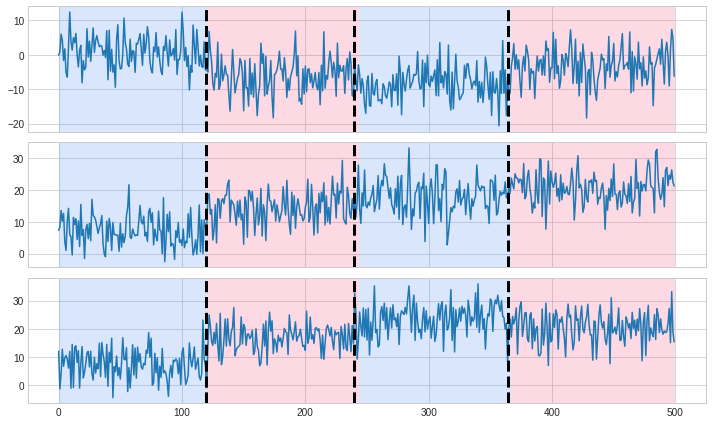

In [51]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 5
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()

In [61]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt

# creation of data
n, dim = 500, 3
n_bkps, sigma = 3, 1
signal, b = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

# change point detection
model = "l1"  # "l2", "rbf"
algo = rpt.Pelt(model=model, min_size=3, jump=5).fit(signal)
my_bkps = algo.predict(pen=3)

# show results
#fig, (ax,) = rpt.display(signal, b, my_bkps, figsize=(10, 6))
#plt.show()

In [63]:
my_bkps

[5,
 10,
 60,
 75,
 120,
 125,
 135,
 245,
 255,
 375,
 380,
 435,
 440,
 465,
 470,
 495,
 500]

In [54]:
import numpy as np
import matplotlib.pylab as plt
import ruptures as rpt
# creation of data
n = 500  # number of samples
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)

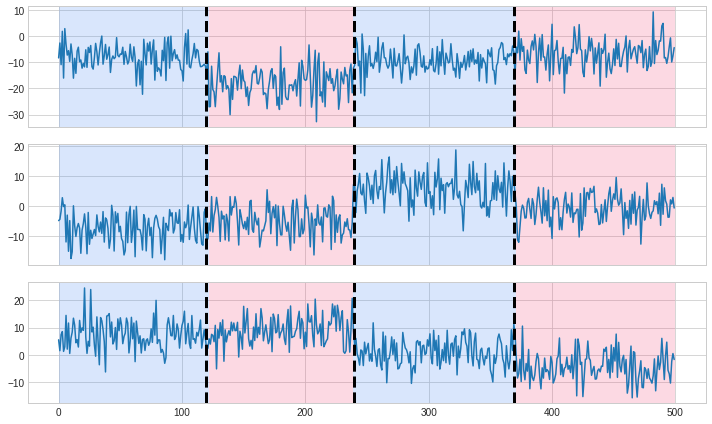

In [55]:
# change point detection
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

# show results
rpt.show.display(signal, bkps, my_bkps, figsize=(10, 6))
plt.show()